In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import scipy as sp
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('/Users/jeffrey/GoogleDrive/PulsarSignalSimulator/PulsarSimulator/')
import VersionZeroPointZero as PSS
from scipy import signal

To avoid hardcoding the DM, I had to write a function that would call both the signal and the pulse, since the DM is an attribute of the signal once the ISM is initialized. 

self1 should be the pulse and self2 should be the signal. I don't know if I like this idea that much and I feel like it would be better if we could give the pulse the DM attribute.

I changed the convolve function to use the scipy convolve instead of numpy, but I can't notice any differences, so it was mostly to make sure it would work fine. 

I added the two lines I deleted back in to keep track of the widths.

In [3]:
def DMBroaden(self1, self2, to_DM_Broaden=True):
    self1.widths = np.zeros(self1.Nf)
    for ii, freq in enumerate(self1.Signal_in.freq_Array):
        sub_band_width = self1.bw/self1.Nf
        width = int(PSS.utils.top_hat_width(sub_band_width, freq, self2.MetaData.DM)//self1.TimeBinSize)
        if width > 0 and to_DM_Broaden:
            if width > self1.Nt:
                raise ValueError('Too Much DM! Dispersion broadening top hat wider than data array!')
            self1.widths[ii] = width
            self1.profile[ii,:] = sp.convolve(self1.profile[ii,:], signal.boxcar(width)/width,'same')
    self1.make_pulses()

**__Cassidy:__** Hi Cassidy! I wanted to write you some notes here so we can do an iteration of this method. It looks great for the first pass! I don't think that we need the `to_DM_Broaden` flag here. We would probably put this outside of this method and only call the method if that flag was true. That would also get rid of the first `if` statement. 

Also, I would rename `self1` and `self2` so that we know what they are. I am (and this just my opinion) always in favor of longer descriptive names rather than short ones. In other methods I refer to them as `signal_object` and `pulsar_object`.

Lastly the `self` designation doesn't quite work the way you are trying to use it. The `self` is the class object that you are working within, if you are working within a class object. Since this will be a utility method then it won't be within a class, so we can't refer to the object via `self`. Does that make sense? If not then it might help to either watch a quick Python tutorial on classes (there are many) or do some googling for something on StackExchange. It's really evident if you look at some code. 

Again, this looks really great!

**__Cassidy:__**  Here is a version that implements some of things I was talking about. What do you think? 
``` python
def DMBroaden(signal_object, pulsar_object):
    dm_widths = np.zeros(self1.Nf)
    for ii, freq in enumerate(pulsar_object.Signal_in.freq_Array):
        sub_band_width = signal_object.bw/signal_object.Nf
        width = int(PSS.utils.top_hat_width(sub_band_width, freq, signal_object.MetaData.DM)//signal_object.TimeBinSize)
        if width > signal_object.Nt:
            raise ValueError('Too Much DM! Dispersion broadening top hat wider than data array!')
        dm_widths[ii] = width
        pulsar_object.profile[ii,:] = sp.convolve(pulsar_object.profile[ii,:],\
            signal.boxcar(width)/width,'same')
    Dict = {'dm_widths', dm_widths}
    signal_object.MetaData.AddInfo(Dict)
    #pulsar_object.make_pulses()
```
**__Cassidy:__** I added in two lines that makes a dictionary with the dm_widths and then adds it to the signal MetaData.

I've commented out the last line because the plan is to call that command once we've done everything to the profiles that we want to. We don't want to sample the pulses until we've convolved with an other curves (like an exponential). Does that make sense? 

Initializing signal, pulse, and ISM.

In [5]:
S1=PSS.Signal(Nt=2000)
P1=PSS.Pulsar(S1)
I1=PSS.ism.ISM(S1)

I couldn't figure out how to call the DM as an attribute of the signal's metadata without actually adding in the ISM_Dict as I did below. And because of the way I went about this, the only way I was able to call a non-NoneType DM was by changing 

self.ISM_Dict = dict(dispersion=False, scattering=False, DM = None, scintillation=False) 

from DM = None to DM = 100 (or any number) inside of ism.py. 

It seems like this AddInfo should be completed inside of both ism.py and pulsar.py so the user doesn't have to call it. Unless of course there was a different way I should have been calling the DM, but this was all I thought made sense.

**__Cassidy:__** I know that we talked about this already, but I did "fix" this issue, I think. The idea is that when you intialize `ISM()` now you can change all the values as you wish, and then when you call `I1.finalize_ism()` it adds all the values to the `Signal.MetaData`, so you should be able to call `Signal.MetaData.DM` to get the DM. I the code above it would be something like `signal_object.MetaData.DM`.

In [5]:
S1.MetaData.AddInfo(I1.ISM_Dict) #DM=100

Just specifying the gaussians to make the plots in this notebook nicer, that way the broadening is more obvious.

In [9]:
peak3 = np.random.randn(20*3)*0.01 + 0.2
width3 = abs(np.random.randn(20*3)*0.002 +0.012)
amp3 = np.random.randn(20*3)**2
peak3.resize(20,3)
width3.resize(20,3)
amp3.resize(20,3)
P1.gauss_template(peak=peak3,width=width3,amp=amp3)

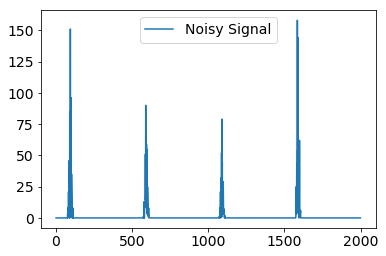

In [10]:
P1.make_pulses()
plt.plot(P1.signal[5],label="Noisy Signal")
plt.legend()
plt.show()

In [11]:
DMBroaden(P1,S1) #Running the method. Make sure to include both the pulse and the signal.

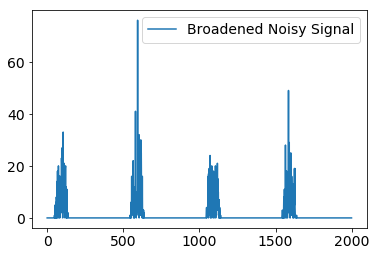

In [12]:
plt.plot(P1.signal[5],label="Broadened Noisy Signal")
plt.legend()
plt.show()